<a href="https://colab.research.google.com/github/Antonio-Villarreal/Deep-Learning-For-Dummies/blob/main/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNET Architecture Introduction

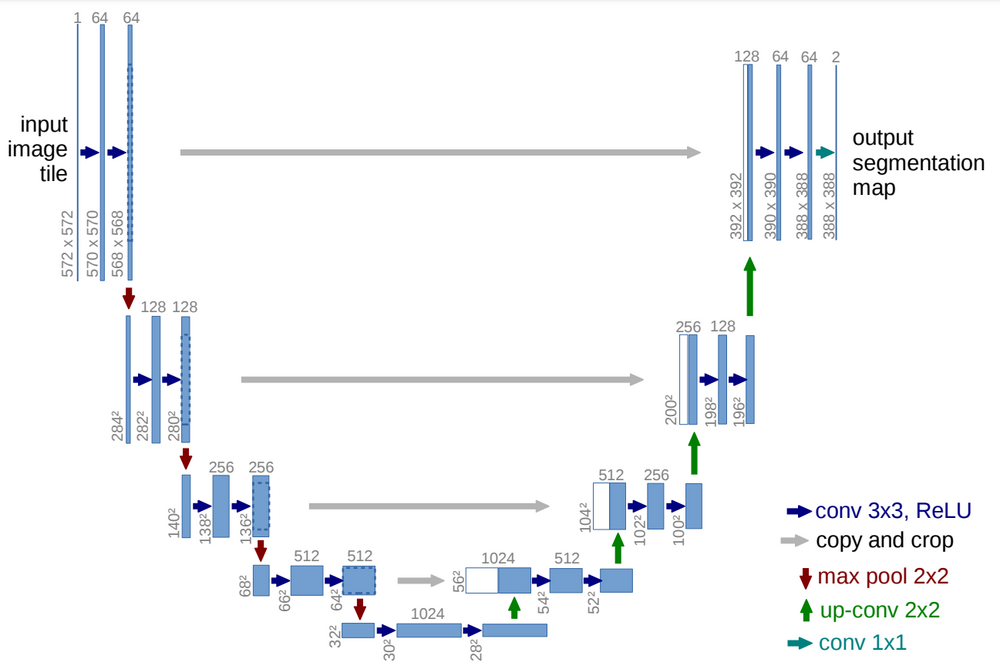

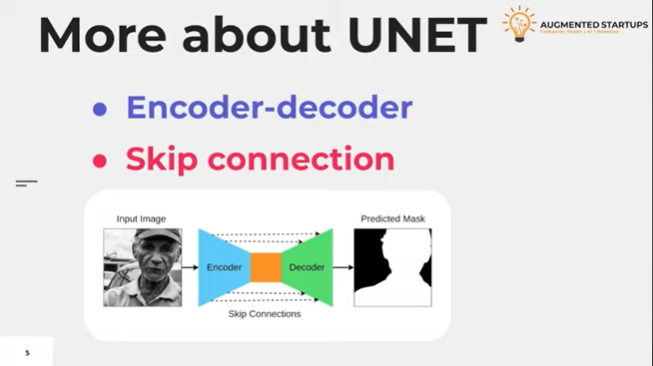

# Improved Carvana

[https://www.kaggle.com/code/seanreed1/draft-unet-segmentation-on-carvana-dataset](https://www.kaggle.com/code/seanreed1/draft-unet-segmentation-on-carvana-dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir /content/data

In [ ]:
import zipfile

# specify the zip file name
zip_file = '/content/gdrive/MyDrive/Deep Learning/carvana-image-masking-challenge.zip'

# specify the directory where you want to extract the files
extraction_path = '/content/data'

# extract the files
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [ ]:
import zipfile

# specify the zip file name
zip_file = '/content/data/train.zip'

# specify the directory where you want to extract the files
extraction_path = '/content/data'

# extract the files
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [ ]:
import zipfile

# specify the zip file name
zip_file = '/content/data/train_masks.zip'

# specify the directory where you want to extract the files
extraction_path = '/content/data'

# extract the files
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [ ]:
import gc
import math
import glob
import os
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.utils
import pytorch_lightning as pl
import torchmetrics as tm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import List
from PIL import Image

In [ ]:
class Block(pl.LightningModule):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias= False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias= False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv(x)

class UNET(pl.LightningModule):
    def __init__(self, in_channels: int=3, out_channels: int=1, features: List=[64,128,256,512], learning_rate=1.5e-3):
        super().__init__()
        self.learning_rate = learning_rate 
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        for feature in features:
            self.down.append(Block(in_channels, feature))
            in_channels=feature
        for feature in reversed(features):
            self.up.append(
                nn.ConvTranspose2d(feature*2, feature, 2, 2)
            )
            self.up.append(
                Block(feature*2, feature) # x gets concat to 2xchannel
            )
        self.bottleneck = Block(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)
        self.loss_fn = nn.BCEWithLogitsLoss()
        
        self.val_num_correct = 0
        self.val_num_pixels = 0
        self.val_dice_score = 0
        self.num_correct = 0
        self.num_pixels = 0
        self.dice_score = 0
    def forward(self, x):
        skip_connections = []
        for down in self.down:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.up), 2):
            x = self.up[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1) # Concat along channels (b, c, h, w)
            x = self.up[idx+1](concat_skip)
        return self.final_conv(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        self.num_correct += (pred == y).sum()
        self.num_pixels += torch.numel(pred)
        self.dice_score += (2 * (pred * y).sum()) / (
            (pred + y).sum() + 1e-8
        )
        self.log('train_loss', loss, logger = True)
        return {'loss': loss}
    
    def training_epoch_end(self, output):
        train_acc = float(f'{(self.num_correct/self.num_pixels)*100:.2f}')
        self.log('train_acc', train_acc, prog_bar = True, logger = True)
        dice_score = self.dice_score/len(output)
        self.log('train_dice_score', dice_score, prog_bar = True, logger = True)
        self.num_correct, self.num_pixels, self.dice_score = 0,0,0
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        self.val_num_correct += (pred == y).sum()
        self.val_num_pixels += torch.numel(pred)
        self.val_dice_score += (2 * (pred * y).sum()) / (
            (pred + y).sum() + 1e-8
        )
        self.log('val_loss', loss, prog_bar = True, logger = True)
        return {'loss': loss}
    
    def validation_epoch_end(self, output):
        val_acc = float(f'{(self.val_num_correct/self.val_num_pixels)*100:.2f}')
        self.log('val_acc', val_acc, prog_bar = True, logger = True)
        dice_score = self.val_dice_score/len(output)
        self.log('val_dice_score', dice_score, prog_bar = True, logger = True)
        self.val_num_correct, self.val_num_pixels, self.val_dice_score = 0,0,0
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(params = self.parameters(), lr = self.learning_rate, weight_decay=0.3)
        return optimizer

In [ ]:
pl.utilities.model_summary.summarize(UNET(),-1)

In [ ]:
class SegmentationDataset(torch.utils.data.Dataset):
  def __init__(self, image_path, mask_path, transforms):
    self.images = glob.glob(os.path.join(image_path, '*.jpg'))
    self.image_path = image_path
    self.mask_path = mask_path
    self.transforms = transforms

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    img = np.array(Image.open(self.images[idx]).convert('RGB'))
    mask = np.array(Image.open(os.path.join(self.mask_path, os.path.basename(self.images[idx]).replace('.jpg', '.png')))) 
    mask[mask == 255.0] = 1.0  
    augmentations = self.transforms(image=img, mask=mask)
    image = augmentations["image"]
    mask = augmentations["mask"]
    mask = torch.unsqueeze(mask, 0)
    mask = mask.type(torch.float32)
    return image, mask

In [ ]:
class SegmentationDataModule(pl.LightningDataModule):
    
    def __init__(self, image_path, mask_path, transform, train_size=0.90, batch_size: int = 9):
        super().__init__()
        self.image_path = image_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.transform = transform
        self.train_size = train_size
        
    def setup(self, stage = None):
        if stage in (None, 'fit'):
            ds = SegmentationDataset(self.image_path, self.mask_path, self.transform)
            train_size = math.floor(len(ds)*self.train_size)
            val_size = len(ds)-train_size
            train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
            self.train_dataset = train_ds
            self.val_dataset = val_ds
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, self.batch_size, num_workers=2, shuffle = True, persistent_workers=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, self.batch_size, num_workers=2, persistent_workers=True)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, self.batch_size)

In [ ]:
torch.cuda.empty_cache()
transform = A.Compose(
    [
        A.Resize(height=360, width=480),
        A.Rotate(limit=45, p=0.7),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        A.pytorch.ToTensorV2(),
    ]
)
ds = SegmentationDataModule('/content/data/train', '/content/data/train_masks', transform=transform)
model = UNET()
if not os.path.isdir('./unet_3'): os.mkdir('./unet_3')
checkpointCallback = pl.callbacks.ModelCheckpoint(dirpath="./unet_3", 
                                                  save_top_k=1, 
                                                  monitor="val_loss",
                                                 filename='{epoch}-{val_loss:.5f}',
                                                 mode='min')
if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=8, accelerator='gpu', gpus=1, 
                         callbacks=[checkpointCallback], profiler='simple',
                         auto_lr_find=True)
else:
    trainer = pl.Trainer(max_epochs=7, accelerator='tpu', tpu_cores=8, 
                         callbacks=[checkpointCallback], profiler='simple', 
                         auto_lr_find=True)

trainer.fit(model, datamodule=ds)

In [ ]:
def save_images(model, loader, folder='val_img', device='cuda'):
    model.eval()
    if not os.path.isdir(folder):
        os.mkdir(folder)
    model.to(device=device)
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        y = y.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x).cuda())
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y, f"{folder}/mask_{idx}.png")       

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def merge_photos(src_folder: str='./val_img', dst_folder: str='./merged_val_img', remove_single: bool=True):
    files = glob.glob(src_folder+'/*.png')
    if not os.path.isdir(dst_folder):
        os.mkdir(dst_folder)
    for i in range(int(len(files)/2)):
        pred_img = Image.open(f'{src_folder}/pred_{i}.png')
        mask_img = Image.open(f'{src_folder}/mask_{i}.png')
        get_concat_v(pred_img, mask_img).save(f'{dst_folder}/merged_pred_mask_{i}.png')
        if remove_single:
            os.remove(f'./val_img/pred_{i}.png')
            os.remove(f'./val_img/mask_{i}.png')

In [ ]:
ds.setup()
save_images(model, ds.val_dataloader())
merge_photos()
# TODO: Implement feature for sampling random img/label pairs for model prediction/eval
#         - Should show output and mask as images, pref side by side or across batches
#         - Conduct additional testing using the competition or data from the internet

# Carvana Image Segmentation (PyTorch)

## Preprocessing

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask


## Utilities

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    batch_size,
    train_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    return train_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

## Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds)
    print(x)
    assert preds.shape == x.shape

## Loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir /content/data
!mkdir /content/data/saved_images/

In [ ]:
import zipfile

# specify the zip file name
zip_file = '/content/gdrive/MyDrive/Deep Learning/carvana-image-masking-challenge.zip'

# specify the directory where you want to extract the files
extraction_path = '/content/data'

# extract the files
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [ ]:
import zipfile

# specify the zip file name
zip_file = '/content/data/train.zip'

# specify the directory where you want to extract the files
extraction_path = '/content/data'

# extract the files
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [ ]:
import zipfile

# specify the zip file name
zip_file = '/content/data/train_masks.zip'

# specify the directory where you want to extract the files
extraction_path = '/content/data'

# extract the files
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

## Train

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS = 2
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "/content/data/train"
TRAIN_MASK_DIR = "/content/data/train_masks"

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for epoch in range(NUM_EPOCHS):
        correct = 0
        total = 0

        for batch_idx, (data, targets) in enumerate(loop):
            data = data.to(device=DEVICE)
            targets = targets.float().unsqueeze(1).to(device=DEVICE)

            # forward
            with torch.cuda.amp.autocast():
                predictions = model(data)
                loss = loss_fn(predictions, targets)

                # calculate accuracy
                predicted = (predictions > 0.5).float()
                correct += (predicted == targets).sum().item()
                total += targets.shape[0]

            # backward
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # update tqdm loop
            accuracy = 100 * correct / total
            loop.set_postfix(loss=loss.item(), accuracy="{:.2f}%".format(accuracy))


In [ ]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    NUM_WORKERS,
    PIN_MEMORY,
)

if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    # checkpoint = {
    #     "state_dict": model.state_dict(),
    #     "optimizer":optimizer.state_dict(),
    # }
    # save_checkpoint(checkpoint)

  9%|▉         | 30/318 [29:57<4:47:35, 59.91s/it, accuracy=3533695.00%, loss=0.334]


KeyboardInterrupt: ignored

# Oxford Pets Dataset Application (TensorFlow)

In [9]:
!mkdir /content/data

mkdir: cannot create directory ‘/content/data’: File exists


In [10]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [11]:
import zipfile

# specify the zip file name
zip_file = '/content/gdrive/MyDrive/Deep Learning/OxfordPets.zip'

# specify the directory where you want to extract the files
extraction_path = '/content/data'

# extract the files
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [12]:
import os

input_dir = "/content/data/OxfordPets/images/"
target_dir = "/content/data/OxfordPets/annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
/content/data/OxfordPets/images/Abyssinian_1.jpg | /content/data/OxfordPets/annotations/trimaps/Abyssinian_1.png
/content/data/OxfordPets/images/Abyssinian_10.jpg | /content/data/OxfordPets/annotations/trimaps/Abyssinian_10.png
/content/data/OxfordPets/images/Abyssinian_100.jpg | /content/data/OxfordPets/annotations/trimaps/Abyssinian_100.png
/content/data/OxfordPets/images/Abyssinian_101.jpg | /content/data/OxfordPets/annotations/trimaps/Abyssinian_101.png
/content/data/OxfordPets/images/Abyssinian_102.jpg | /content/data/OxfordPets/annotations/trimaps/Abyssinian_102.png
/content/data/OxfordPets/images/Abyssinian_103.jpg | /content/data/OxfordPets/annotations/trimaps/Abyssinian_103.png
/content/data/OxfordPets/images/Abyssinian_104.jpg | /content/data/OxfordPets/annotations/trimaps/Abyssinian_104.png
/content/data/OxfordPets/images/Abyssinian_105.jpg | /content/data/OxfordPets/annotations/trimaps/Abyssinian_105.png
/content/data/OxfordPets/images/Abyssinian_106

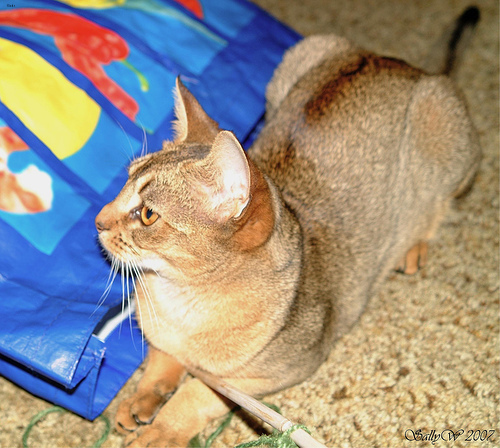

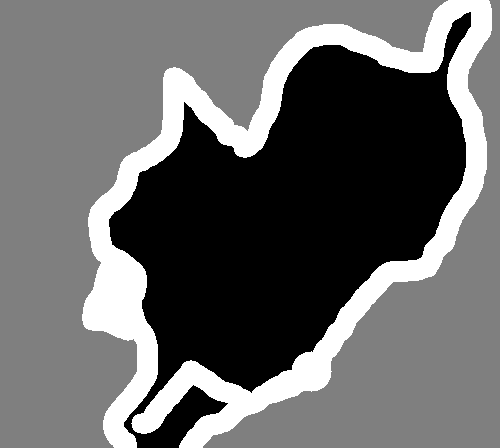

In [13]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [14]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [15]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)


In [16]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

In [17]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

In [18]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

In [19]:
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [20]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(3, 1, padding="same", activation="sigmoid")(decoder_4)
    # out = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

In [21]:
input_shape = (160, 160, 3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
798/798 [==============================] - 203s 235ms/step - loss: 0.6442 - val_loss: 0.5581
Epoch 2/15
798/798 [==============================] - 189s 237ms/step - loss: 0.4735 - val_loss: 0.7155
Epoch 3/15
259/798 [========>.....................] - ETA: 2:01 - loss: 0.4104

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 1000

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.